In [1]:
# Group Members:
# Caprichia Jeffers - caprichia.jeffers@chase.com
# zheng li zheng.li@chase.com
# Sajid Rauf: - sajid.m.rauf@chase.com
# Stephen McCoy - stephen.w.mccoy@jpmchase.com
# zhuyu.you@chase.com

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

pd.options.display.max_columns = 150

# 0. Create Dataset

In [4]:
file_url = './datasets/application_train.csv'
df = pd.read_csv(file_url)
df['split'] = 'train'

In [5]:
file_url = './datasets/application_test.csv'
test_df = pd.read_csv(file_url)
test_df['split'] = 'test'

In [6]:
df = pd.concat([df, test_df])

# 1. Data Quality Checks
    - Missingness and Outliers

In [7]:
df.shape

(356255, 123)

In [8]:
df.sample(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,split
238684,376451,0.0,Cash loans,M,Y,Y,1,180000.0,187659.0,21352.5,162000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.032561,-14058,-2931,-6675.0,-5296,3.0,1,1,0,1,1,0,Drivers,3.0,1,1,FRIDAY,17,0,0,0,0,0,0,Business Entity Type 1,NaN,0.724236,NaN,0.2634,0.1955,0.9806,0.7348,NaN,0.28,0.2414,0.3333,0.375,0.0824,0.2181,0.2718,0.0019,0.0027,0.2542,0.1999,0.9806,0.7452,NaN,0.282,0.2414,0.3333,0.375,0.0843,0.2296,0.2804,0.0,0.0,0.2660,0.1955,0.9806,0.7383,NaN,0.28,0.2414,0.3333,0.375,0.0839,0.2219,0.2767,0.0019,0.0028,reg oper account,block of flats,0.2122,Panel,No,0.0,0.0,0.0,0.0,-473.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,train
107594,224820,0.0,Cash loans,M,N,Y,2,202500.0,113760.0,9117.0,90000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.030755,-14641,-183,-439.0,-2269,NaN,1,1,0,1,0,0,Cooking staff,4.0,2,2,TUESDAY,9,0,0,0,0,1,1,Business Entity Type 3,0.216647,0.327450,0.367291,0.0155,NaN,0.9786,NaN,NaN,NaN,0.0690,0.0417,NaN,0.0143,NaN,0.0124,NaN,NaN,0.0158,NaN,0.9786,NaN,NaN,NaN,0.0690,0.0417,NaN,0.0146,NaN,0.0130,NaN,NaN,0.0156,NaN,0.9786,NaN,NaN,NaN,0.0690,0.0417,NaN,0.0145,NaN,0.0127,NaN,NaN,NaN,NaN,0.0098,"Stone, brick",No,3.0,0.0,2.0,0.0,-389.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0,train
283592,428443,0.0,Cash loans,F,N,Y,0,157500.0,781920.0,24682.5,675000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.003069,-19954,365243,-1570.0,-2251,NaN,1,0,0,1,0,0,NaN,2.0,3,3,FRIDAY,15,0,0,0,0,0,0,XNA,NaN,0.526606,0.604113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 123 entries, SK_ID_CURR to split
dtypes: float64(66), int64(40), object(17)
memory usage: 337.0+ MB


In [10]:
# drop columns with 60+% missing
miss_tbl = (df.isna().sum()/df.shape[0]).sort_values(ascending=False).reset_index()
#list(miss_tbl[miss_tbl[0]>0.6]['index'].unique())
df_nomiss60 = df.drop(columns=list(miss_tbl[miss_tbl[0]>0.6]['index'].unique()))

In [11]:
df_nomiss60.shape

(356255, 106)

In [12]:
# drop highly correlated measure (keep median; drop ang, mode)
df_drop = df_nomiss60.drop(columns=list(df_nomiss60.columns[df_nomiss60.columns.str.contains('AVG|MODE')]))

In [13]:
df_drop.shape

(356255, 84)

In [14]:
df_drop.TARGET.isna().sum()

48744

In [15]:
df_drop.TARGET.value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

In [16]:
df_drop.dtypes.value_counts()

int64      40
float64    31
object     13
dtype: int64

In [17]:
# Create correlation matrix
corr_mat = df_drop.corr(method='pearson')
  
# Retain upper triangular values of correlation matrix and
# make Lower triangular values Null
upper_corr_mat = corr_mat.where(
    np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
  
# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values()

In [18]:
sorted_mat[sorted_mat > 0.8].tail(25)

LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.825766
ELEVATORS_MEDI               APARTMENTS_MEDI               0.837846
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.857576
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.865257
LIVINGAREA_MEDI              ELEVATORS_MEDI                0.868184
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.878912
LIVINGAREA_MEDI              APARTMENTS_MEDI               0.915138
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.949647
AMT_GOODS_PRICE              AMT_CREDIT                    0.987159
OBS_60_CNT_SOCIAL_CIRCLE     OBS_30_CNT_SOCIAL_CIRCLE      0.998768
dtype: float64

In [19]:
sorted_mat[sorted_mat < -0.8]

FLAG_EMP_PHONE  DAYS_EMPLOYED   -0.999766
dtype: float64

In [20]:
# drop 1 variable with correlation of 0.8+
list(pd.DataFrame(sorted_mat[(sorted_mat < -0.8) | (sorted_mat > 0.8)]).reset_index()['level_0'])

['FLAG_EMP_PHONE',
 'LIVE_CITY_NOT_WORK_CITY',
 'ELEVATORS_MEDI',
 'LIVE_REGION_NOT_WORK_REGION',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'LIVINGAREA_MEDI',
 'CNT_FAM_MEMBERS',
 'LIVINGAREA_MEDI',
 'REGION_RATING_CLIENT_W_CITY',
 'AMT_GOODS_PRICE',
 'OBS_60_CNT_SOCIAL_CIRCLE']

In [21]:
df2 = (
    df_drop
    .drop(columns={'FLAG_EMP_PHONE',
 'LIVE_CITY_NOT_WORK_CITY',
 'ELEVATORS_MEDI',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'LIVE_REGION_NOT_WORK_REGION',
 'LIVINGAREA_MEDI',
 'CNT_FAM_MEMBERS',
 'LIVINGAREA_MEDI',
 'REGION_RATING_CLIENT_W_CITY',
 'AMT_GOODS_PRICE',
 'OBS_60_CNT_SOCIAL_CIRCLE'})
)
df2.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,NONLIVINGAREA_MEDI,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,split
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,0,1,1,0,Laborers,2,WEDNESDAY,10,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0250,0.0369,0.9722,0.0690,0.0833,0.0375,0.00,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,0,1,1,0,Core staff,1,MONDAY,11,0,0,0,0,School,0.311267,0.622246,NaN,0.0968,0.0529,0.9851,0.0345,0.2917,0.0132,0.01,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,0,Laborers,2,MONDAY,9,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,0,1,0,0,Laborers,2,WEDNESDAY,17,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,train
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,0,1,0,0,Core staff,2,THURSDAY,11,0,0,0,1,Religion,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [22]:
df2.dtypes.value_counts()

int64      36
float64    25
object     13
dtype: int64

In [23]:
pd.Series(df2.isna().sum()/df2.shape[0]).sort_values(ascending=False).head(10)

LANDAREA_MEDI                   0.591835
BASEMENTAREA_MEDI               0.582684
NONLIVINGAREA_MEDI              0.549511
EXT_SOURCE_1                    0.544301
APARTMENTS_MEDI                 0.505110
ENTRANCES_MEDI                  0.500785
FLOORSMAX_MEDI                  0.494985
YEARS_BEGINEXPLUATATION_MEDI    0.485223
OCCUPATION_TYPE                 0.314370
EXT_SOURCE_3                    0.195458
dtype: float64

In [24]:
profile = ProfileReport(df2, minimal=True)
profile.to_file("df2_profile_output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
# Impute Missing Values
df2 = df2.fillna(df2.median())

/var/folders/hn/3wwh9yy571jbqjltnqglztg80000gn/T/ipykernel_18018/2001685126.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df2 = df2.fillna(df2.median())


In [26]:
pd.Series(df2.isna().sum()/df2.shape[0]).sort_values(ascending=False).head(10)

OCCUPATION_TYPE    0.314370
NAME_TYPE_SUITE    0.006184
SK_ID_CURR         0.000000
FLAG_DOCUMENT_8    0.000000
FLAG_DOCUMENT_7    0.000000
FLAG_DOCUMENT_6    0.000000
FLAG_DOCUMENT_5    0.000000
FLAG_DOCUMENT_4    0.000000
FLAG_DOCUMENT_3    0.000000
FLAG_DOCUMENT_2    0.000000
dtype: float64

In [27]:
numerics = ['int64', 'float64', 'int32', 'int16']
catDf = df2.select_dtypes(exclude=numerics)
numDf = df2.select_dtypes(include=numerics)

In [28]:
catDf.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,split
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,train
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,train
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,train
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,train
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,train


In [29]:
df2[list(catDf.columns)] = df2[list(catDf.columns)].astype('category')

In [30]:
df2.dtypes.value_counts()

int64       36
float64     25
category     2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
dtype: int64

In [31]:
tbl = pd.DataFrame(numDf.nunique().sort_values(ascending=True)).reset_index()
#list(tbl[(tbl[0]>2) & (tbl[0]<21)]['index'])
num_to_cat_cols = ['REGION_RATING_CLIENT',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_QRT']
df2[num_to_cat_cols] = df2[num_to_cat_cols].astype('category')

In [32]:
df2.dtypes.value_counts()

int64       35
float64     21
category     2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
dtype: int64

In [33]:
catDf2 = df2.select_dtypes(exclude=numerics).drop(columns={'split'})
numDf2 = df2.select_dtypes(include=numerics).drop(columns={'TARGET'})

In [34]:
# One Hot Encoding & Scaling
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
transformer = make_column_transformer(  # this function scales and encodes our data in 1 step
    (MinMaxScaler(), # columns to scale
        list(numDf2.columns)),
    (OneHotEncoder(handle_unknown='ignore'), # columns to encode
        list(catDf2.columns))
)

In [35]:
#from sklearn.model_selection import train_test_split
df_train = df2[df2.split=='train'].drop(columns={'split'})
df_test = df2[df2.split=='test'].drop(columns={'split'})

In [36]:
df_train.TARGET.value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

In [37]:
# Undersample
ind = df_train[df_train['TARGET']==1].index
print(len(ind))

24825


In [38]:
minData = df_train.loc[ind]
print(minData.shape)

(24825, 73)


In [39]:
ind1 = df_train[df_train['TARGET']==0].index
print(len(ind1))

282686


In [40]:
majData = df_train.loc[ind1]
print(majData.shape)
majData.head()

(282686, 73)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,NONLIVINGAREA_MEDI,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,0,1,1,0,Core staff,1,MONDAY,11,0,0,0,0,School,0.311267,0.622246,0.533482,0.0968,0.0529,0.9851,0.0345,0.2917,0.0132,0.0100,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,0,Laborers,2,MONDAY,9,0,0,0,0,Government,0.506155,0.555912,0.729567,0.0874,0.0761,0.9816,0.1379,0.1667,0.0487,0.0031,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,0,1,0,0,Laborers,2,WEDNESDAY,17,0,0,0,0,Business Entity Type 3,0.506155,0.650442,0.533482,0.0874,0.0761,0.9816,0.1379,0.1667,0.0487,0.0031,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,0,1,0,0,Core staff,2,THURSDAY,11,0,0,0,1,Religion,0.506155,0.322738,0.533482,0.0874,0.0761,0.9816,0.1379,0.1667,0.0487,0.0031,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0.0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970.0,-477,1,1,1,1,0,Laborers,2,WEDNESDAY,16,0,0,0,0,Other,0.506155,0.354225,0.621226,0.0874,0.0761,0.9816,0.1379,0.1667,0.0487,0.0031,0.0,0.0,-2536.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [41]:
majSample = majData.sample(n=len(ind),random_state = 123) # Extracting out 282686 Records (the len of ind)
"""
Concatenating both data sets and then shuffling the data set
"""
balData = pd.concat([minData,majSample],axis = 0)

In [42]:
# Shuffling the data set
from sklearn.utils import shuffle
balData = shuffle(balData)
balData.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,NONLIVINGAREA_MEDI,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
69350,180437,0.0,Revolving loans,F,Y,Y,0,90000.0,270000.0,13500.0,Unaccompanied,Pensioner,Higher education,Married,House / apartment,0.020713,-20451,365243,-9992.0,-3661,1,0,1,0,0,NaN,3,SATURDAY,10,0,0,0,0,XNA,0.698607,0.413121,0.526295,0.0874,0.0761,0.9816,0.1379,0.1667,0.0487,0.0031,0.0,0.0,-456.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
277570,421613,0.0,Cash loans,F,Y,Y,0,103500.0,808650.0,23773.5,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018850,-15613,-5091,-8728.0,-3997,1,0,1,0,0,Sales staff,2,TUESDAY,13,0,0,0,0,Self-employed,0.506155,0.631325,0.800451,0.0874,0.0761,0.9816,0.1379,0.1667,0.0487,0.0031,1.0,0.0,-2498.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4655,105443,1.0,Cash loans,M,Y,Y,2,180000.0,790434.0,40486.5,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.046220,-14444,-292,-2351.0,-791,1,0,1,0,0,Managers,1,TUESDAY,15,0,0,1,1,Business Entity Type 3,0.506155,0.331198,0.429424,0.0874,0.0761,0.9816,0.1379,0.1667,0.0487,0.0031,0.0,0.0,-820.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
137020,258918,1.0,Revolving loans,M,Y,N,1,135000.0,180000.0,9000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.008068,-13031,-3180,-1893.0,-4248,1,0,1,0,0,Laborers,3,FRIDAY,6,0,0,0,0,Business Entity Type 3,0.088946,0.093991,0.540654,0.0781,0.0909,0.9866,0.1724,0.1667,0.0723,0.0000,3.0,2.0,-1577.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
133804,255185,0.0,Cash loans,F,N,Y,0,157500.0,337500.0,26793.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-8986,-1782,-3753.0,-833,1,0,1,0,0,Laborers,2,WEDNESDAY,16,0,0,0,1,Industry: type 11,0.506155,0.373603,0.415347,0.0021,0.0761,0.9821,0.1379,0.0000,0.0487,0.0031,6.0,1.0,-82.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,3.0


In [43]:
X_train = balData.drop('TARGET', axis=1)
X_test = df_test.drop('TARGET', axis=1)
y_train = balData['TARGET']
y_test = df_test['TARGET']

In [44]:
# Fit
transformer.fit(X_train)
# Apply the transformation
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [45]:
# build the model

In [46]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [47]:
# How to track the LOSS of the model:
def rmse(y_true, y_pred):    
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [97]:
tf.random.set_seed(42)
model = Sequential([
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1,activation='sigmoid')
])
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100


/Users/zheng/tensorflow-test/env/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


   6/1552 [..............................] - ETA: 15s - loss: 1.0383 - accuracy: 0.5260 - precision: 0.5429 - recall: 0.5700  

2022-06-05 16:39:32.740618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1552/1552 [==============================] - 14s 9ms/step - loss: 0.6307 - accuracy: 0.6498 - precision: 0.6467 - recall: 0.6604
Epoch 2/100
1552/1552 [==============================] - 13s 9ms/step - loss: 0.6152 - accuracy: 0.6673 - precision: 0.6657 - recall: 0.6721
Epoch 3/100
1552/1552 [==============================] - 13s 8ms/step - loss: 0.6085 - accuracy: 0.6691 - precision: 0.6754 - recall: 0.6511
Epoch 4/100
1552/1552 [==============================] - 12s 8ms/step - loss: 0.6114 - accuracy: 0.6689 - precision: 0.6722 - recall: 0.6593
Epoch 5/100
1552/1552 [==============================] - 13s 8ms/step - loss: 0.6106 - accuracy: 0.6693 - precision: 0.6726 - recall: 0.6598
Epoch 6/100
1552/1552 [==============================] - 13s 8ms/step - loss: 0.6083 - accuracy: 0.6703 - precision: 0.6749 - recall: 0.6571
Epoch 7/100
1552/1552 [==============================] - 13s 8ms/step - loss: 0.6088 - accuracy: 0.6717 - precision: 0.6746 - recall: 0.6634
Epoch 8/100
1552/1552 [==

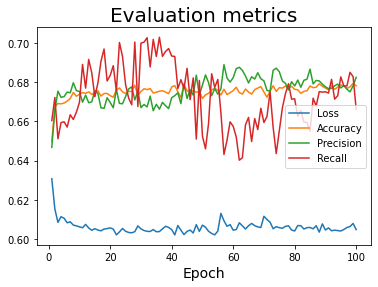

In [104]:
plt.plot(
    np.arange(1, 101), 
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, 101), 
    history.history['accuracy'], label='Accuracy'
)
plt.plot(
    np.arange(1, 101), 
    history.history['precision'], label='Precision'
)
plt.plot(
    np.arange(1, 101), 
    history.history['recall'], label='Recall'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

In [105]:
predictions = model.predict(X_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

In [106]:
predictions = np.ravel(predictions)
predictions[:5]

array([0, 1, 0, 0, 1])

In [107]:
rmse(y_test, predictions).numpy()

0.6626076581081904

In [108]:
rmse(y_test, predictions).numpy()

0.6626076581081904

In [109]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predictions))

[[27343 21401]
 [    0     0]]


In [110]:
df_train['AMT_INCOME_TOTAL'].skew()

391.5596541041876

In [ ]:
# impute missing values
(df_drop.isna().sum()/df_drop.shape[0]).sort_values()

In [ ]:
(list(set(list(obj_df.columns) + list(cat_cnt[cat_cnt[0]==2]['index'])))).nunique()

In [ ]:
cat_cnt = df_drop.nunique().sort_values().reset_index()
obj_cols = list(cat_cnt[cat_cnt[0]==2]['index'])
for col_name in obj_cols:
    df_drop[col_name] = df_drop[col_name].astype('category')

obj_df = df_drop.select_dtypes(include=[object])
obj_cols = list(obj_df.columns)
for col_name in obj_cols:
    df_drop[col_name] = df_drop[col_name].astype('category')

In [ ]:
df_drop.dtypes.value_counts()

In [ ]:
# To calculate mean use imputer class
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(df_drop.drop(columns=list(cat_cnt[cat_cnt[0]==2]['index'])).select_dtypes(exclude=[object]))
  
df_imp = imputer.transform(df_drop.drop(columns=list(cat_cnt[cat_cnt[0]==2]['index'])).select_dtypes(exclude=[object]))
df_imp

In [ ]:
df.dtypes.loc[(df.isna().sum()/df.shape[0]).sort_values(ascending=False).head(20).index]

In [ ]:
# profile = ProfileReport(df)
# profile.to_widgets()
# For large datasets
profile = ProfileReport(df, minimal=True)

In [ ]:
profile.to_file("df_profile_output.html")

In [ ]:
df.duplicated().sum()

In [ ]:
corr_outcome = df.corr(method='pearson')['TARGET'].sort_values()
corr_outcome

In [ ]:
# Create correlation matrix
corr_mat = df.TARGET.to_frame().corrwith(df)
#df1.corrwith(df2, axis = 0)
  
# Retain upper triangular values of correlation matrix and
# make Lower triangular values Null
upper_corr_mat = corr_mat.where(
    np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
  
# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values()

In [ ]:
df.select_dtypes('int').columns

In [ ]:
#num_tbl = df.select_dtypes(exclude=[object]).describe().T.reset_index()
df.describe().T.reset_index().query('min==0.0')

In [ ]:
cat_cols = df.select_dtypes(include=[object])

num_cols = df.select_dtypes(exclude=[object])

In [ ]:
# numeric scaling
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
transformer = make_column_transformer(  # this function scales and encodes our data in 1 step
    (MinMaxScaler(), # columns to scale
        num_cols),
    (OneHotEncoder(handle_unknown='ignore'), # columns to encode
        cat_cols)
)

In [ ]:
2. Data Cleaning
3. EDA (Provide insights based on ANALYSIS prior to building the model)
    - Training data only
    - Include description and conclusions
4. Scaling/Normalizing/OHE
    - Update appropriate EDA
5. Algorithm Harness to choose the BEST model
    - Leverage code at begining of course to get output from different methods
    - Choose two models (likley logistic and NN) to build and compare
6. Hyperparameter Tuning
7. Create a Web Service from your model and call it from a Web Application